In [9]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sn

data_folder = Path("./titanic")
test_path = data_folder / "test.csv"
train_path = data_folder / "train.csv"

In [12]:
data_original = pd.read_csv(train_path)

In [18]:
data = data_original.copy()

In [14]:
data.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
649,650,1,3,"Stanley, Miss. Amy Zillah Elsie",female,23.0,0,0,CA. 2314,7.5500,NaN,S
779,780,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S
820,821,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
714,715,0,2,"Greenberg, Mr. Samuel",male,52.0,0,0,250647,13.0000,NaN,S
653,654,1,3,"O'Leary, Miss. Hanora ""Norah""",female,NaN,0,0,330919,7.8292,NaN,Q


In [19]:
data.drop(columns=["Name", "PassengerId"], inplace=True)

In [22]:
data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [30]:
for col in data.select_dtypes(exclude="number"):
    print(f"{col}:\n{data[col].value_counts()}\n")

Sex:
male      577
female    314
Name: Sex, dtype: int64

Ticket:
347082      7
1601        7
CA. 2343    7
347088      6
CA 2144     6
           ..
237668      1
14311       1
347069      1
2649        1
31418       1
Name: Ticket, Length: 681, dtype: int64

Cabin:
C23 C25 C27    4
B96 B98        4
G6             4
D              3
F33            3
              ..
C47            1
C85            1
C46            1
T              1
E17            1
Name: Cabin, Length: 147, dtype: int64

Embarked:
S    644
C    168
Q     77
Name: Embarked, dtype: int64



In [31]:
data.drop(columns=["Ticket", "Cabin"], inplace=True)

In [37]:
data["Survived"] = data["Survived"].astype("category")
data["Sex"] = data["Sex"].astype("category")
data["Embarked"] = data["Embarked"].astype("category")

In [38]:
data.dtypes

Survived    category
Pclass         int64
Sex         category
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Embarked    category
dtype: object

In [44]:
data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

In [43]:
data.dropna(subset=["Embarked"], inplace=True)

<AxesSubplot:xlabel='Age', ylabel='Count'>

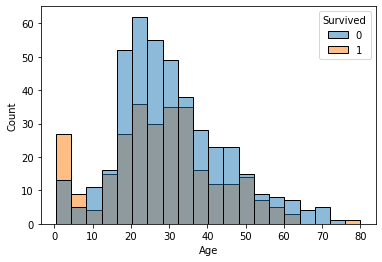

In [46]:
sn.histplot(data=data, x="Age", hue="Survived")